In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
from fbprophet import Prophet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [2]:
df=pd.read_csv("data/sorted_data.csv").iloc[:,1:]

In [3]:
df

,DateTime,AQI-IN,AQI-US,PM25,PM10,PM1,AQI-IN(2),AQI-US(2),PM25(2),PM10(2),PM1(2),Temp(cel),Hum,Noise,Light
0,2019-11-12 00:00:00,668.76,499.96,541.09,645.17,227.84,816.00,500.00,595.00,763.00,270.00,19.66,62.00,42.39,48332.0
1,2019-11-12 01:00:00,672.40,500.00,548.99,648.20,233.32,852.99,500.00,610.07,792.48,279.21,19.74,62.92,41.83,48332.0
2,2019-11-12 02:00:00,696.34,500.00,567.10,667.22,237.52,882.38,500.00,628.13,815.98,287.19,20.00,63.18,46.24,48332.0
3,2019-11-12 03:00:00,754.72,500.00,602.54,714.00,242.85,898.00,500.00,675.00,829.00,295.00,18.35,65.89,40.05,48332.0
4,2019-11-12 04:00:00,884.74,500.00,662.52,818.20,251.60,898.00,500.00,675.00,829.00,295.00,18.14,66.43,39.55,48332.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2020-02-09 19:00:00,379.22,272.65,223.41,251.66,132.72,302.00,185.00,123.00,142.00,76.00,18.04,66.07,46.18,48332.0
2156,2020-02-09 20:00:00,403.84,303.74,255.52,287.45,144.59,386.89,284.95,233.93,286.49,135.12,17.04,71.05,48.36,48332.0
2157,2020-02-09 21:00:00,414.45,315.31,269.58,312.97,144.94,403.00,304.00,255.00,315.00,146.00,16.68,74.01,49.36,48332.0
2158,2020-02-09 22:00:00,429.09,329.78,288.00,333.39,152.60,452.72,355.56,319.46,408.92,175.47,16.11,78.23,45.22,48332.0


In [4]:
df.dtypes

DateTime      object
AQI-IN       float64
AQI-US       float64
PM25         float64
PM10         float64
PM1          float64
AQI-IN(2)    float64
AQI-US(2)    float64
PM25(2)      float64
PM10(2)      float64
PM1(2)       float64
Temp(cel)    float64
Hum          float64
Noise        float64
Light        float64
dtype: object

In [5]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.set_index('DateTime')

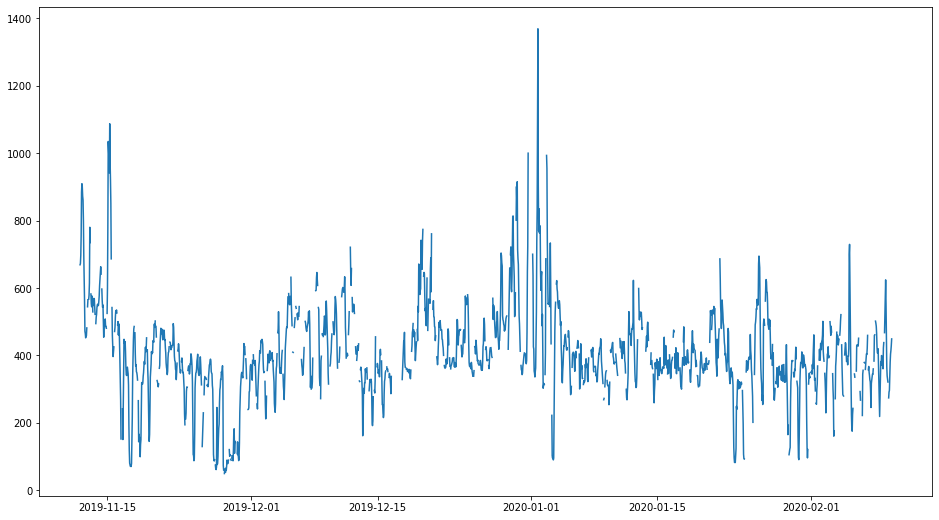

In [6]:
plt.figure(figsize=(16,9))
plt.plot(df["AQI-IN"])

In [11]:
ts=df["AQI-IN"].interpolate('linear')
ts.index=df.index

# ADF検定  

単位根過程（非定常過程）かどうかの検定  
時系列解析は定常性が鍵  
→p値　が5%以下ならば定常と言える  

In [13]:
# トレンド項あり(2次まで)、定数項あり
res_ctt=sm.tsa.stattools.adfuller(ts, regression="ctt")
# トレンド項あり（１次まで）、定数項あり
res_ct=sm.tsa.stattools.adfuller(ts, regression="ct")
# トレンド項なし、定数項あり
res_c=sm.tsa.stattools.adfuller(ts, regression="c")
# トレンド項なし、定数項なし
res_nc=sm.tsa.stattools.adfuller(ts, regression="nc")

print(res_ctt)
print(res_ct)
print(res_c)
print(res_nc)

(-4.942729783646961, 0.0012847173263871412, 26, 2133, {'1%': -4.376570724895482, '5%': -3.8351614869201587, '10%': -3.5549768755046633}, 21604.361331983968)
(-4.699428681636591, 0.0006995405068146601, 26, 2133, {'1%': -3.9630205659606585, '5%': -3.412550312358138, '10%': -3.1282630544070735}, 21605.133076643666)
(-4.7203297460607025, 7.705602603762726e-05, 26, 2133, {'1%': -3.433419473570619, '5%': -2.862895974588963, '10%': -2.5674918550982277}, 21603.31384631137)
(-1.408948859491848, 0.1479911752675942, 26, 2133, {'1%': -2.56678899222782, '5%': -1.9411266623195413, '10%': -1.6166960744544883}, 21621.849821473785)


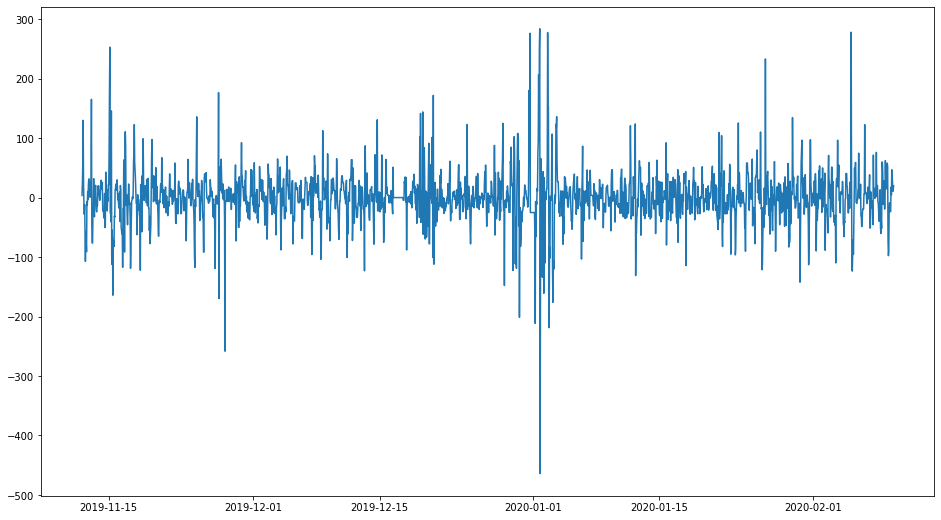

In [19]:
#差分
ts_diff=ts.diff().dropna()
plt.figure(figsize=(16,9))
plt.plot(ts_diff)

# ARIMAのパラメータ推定

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
param=sm.tsa.arma_order_select_ic(ts_diff, ic="aic", trend="nc")
param

{'aic':               0             1             2
 0           NaN  22229.681537  22215.791789
 1  22208.054955  22209.992389  22151.361768
 2  22209.990952  22087.235340  22055.273101
 3  22211.981845  22070.513135  22026.371351
 4  22193.583133  22049.373594  22028.364999, 'aic_min_order': (3, 2)}

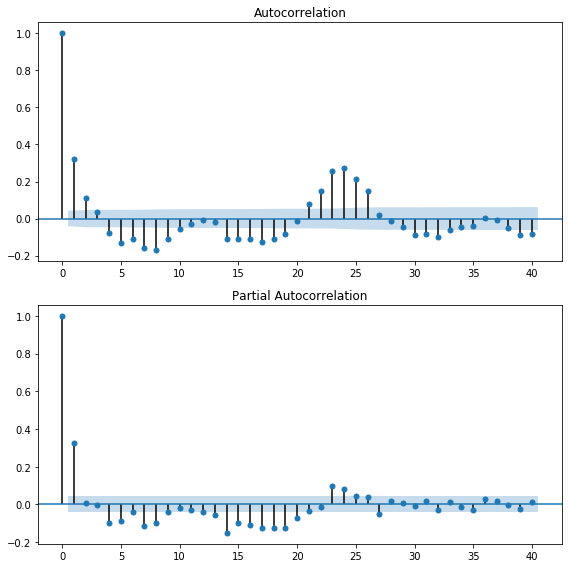

In [30]:
##一回階差の自己相関

fig = plt.figure(figsize=(8, 8))
# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(ts.diff().dropna() , lags=40, ax=ax1) 

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(ts.diff().dropna(), lags=40, ax=ax2) 

plt.tight_layout()

# SARIMAモデル

In [31]:
sarimax=sm.tsa.SARIMAX(ts,
                      order=(3,1,2),
                      seasonal_order=(1,1,1,24),
                       enforce_stationaly=False,
                       enforce_invertibility = False
                      ).fit()

In [32]:
#モデルの残差
sarimax_resid = sarimax.resid

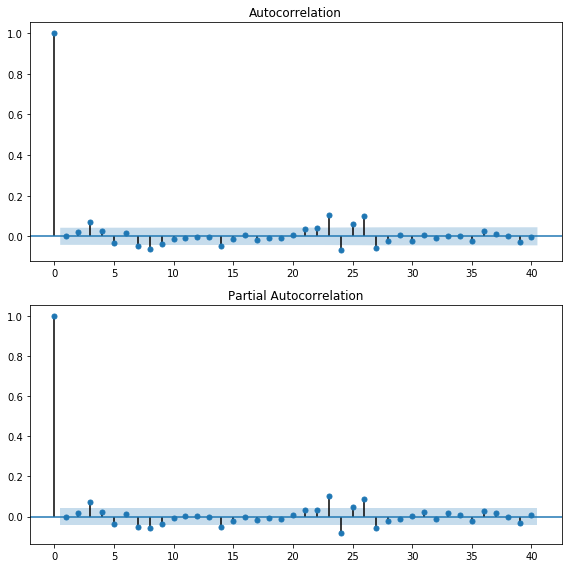

In [33]:
##モデルの残差の自己相関

fig = plt.figure(figsize=(8, 8))
# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid , lags=40, ax=ax1) 

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=40, ax=ax2) 

plt.tight_layout()


In [34]:
sarimax.aic

21788.315549032737

# 自動化

ーーーーーーーーーー2020-01-21 00:00:00〜2020-01-27 23:00:00の予測ーーーーーーーーーー


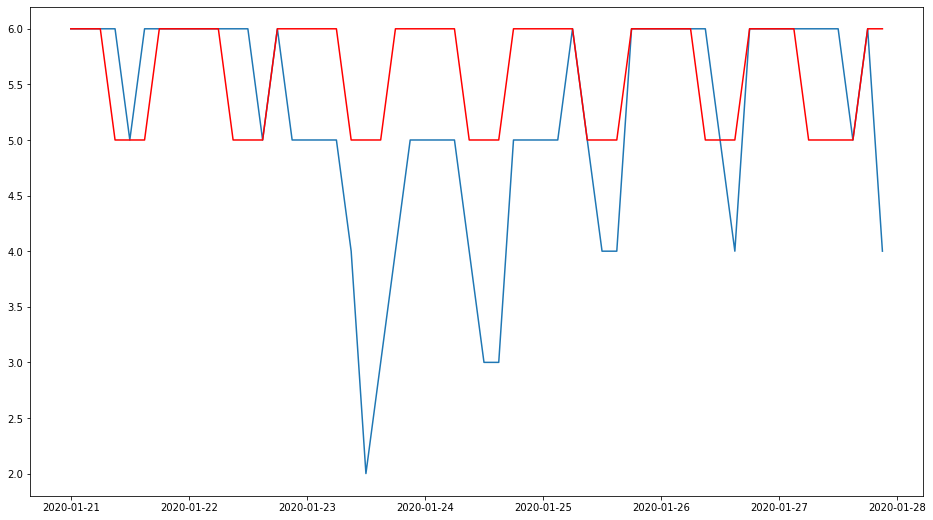

0.6785714285714286
[0.6785714285714286]
ーーーーーーーーーー2020-01-22 00:00:00〜2020-01-28 23:00:00の予測ーーーーーーーーーー


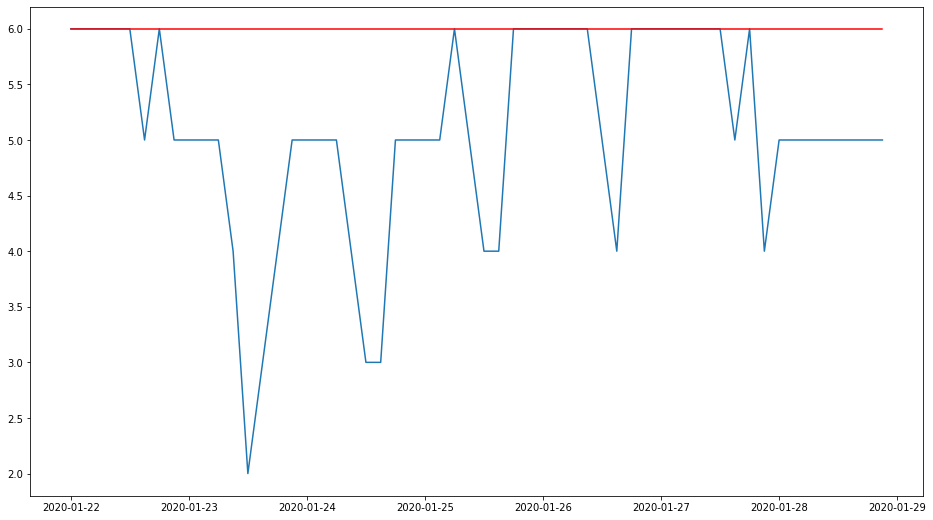

0.9107142857142857
[0.6785714285714286, 0.9107142857142857]


LinAlgError: LU decomposition error.

In [86]:
def aqi_numeric(x):
    if x>=0 and x<=50:
        return 1
    elif x>50 and x<=100:
        return 2
    elif x>100 and x<=200:
        return 3
    elif x>200 and x<=300:
        return 4
    elif x>300 and x<=400:
        return 5
    elif x>400 :
        return 6

#トレーニングデータの数(70日*24)
len_train=1680

score=[]

#1日ずらしながら7回精度評価を行う
for i in range(7):

    #train-testの分割
    ts=df.iloc[0:len_train, :]["AQI-IN"].interpolate('linear')
    test=df.iloc[len_train:len_train+24*7,:]["AQI-IN"].interpolate('linear')

    #一回差分の計算
    ts_diff=ts.diff().dropna()

    #パラメータ推定
    param=sm.tsa.arma_order_select_ic(ts_diff, ic="aic", trend="nc")
    p, q=param["aic_min_order"]

    #モデリング
    sarimax=sm.tsa.SARIMAX(ts,
                          order=(p,1,q),
                          seasonal_order=(1,1,1,24),
                           enforce_stationaly=False,
                           enforce_invertibility = False
                          ).fit()



    #現在の時間
    now=ts.index[-1]

    #１時間後から7日後まで予測するための時間の作成
    forecast_1hour=now + datetime.timedelta(hours=1)
    forecast_7day=now + datetime.timedelta(hours=24*7)
    #文字列に変更
    forecast_1hour=forecast_1hour.strftime("%Y-%m-%d %H:%M:%S")
    forecast_7day=forecast_7day.strftime("%Y-%m-%d %H:%M:%S")
    print("ーーーーーーーーーー"+str(forecast_1hour)+ "〜"+str(forecast_7day)+ "の予測ーーーーーーーーーー")

    #予測(引数は文字列で与える)
    sarimax_pred=sarimax.predict(forecast_1hour, forecast_7day)

    #実測値・予測値を数値カテゴリ(1~6)に変換
    df_forecast1=pd.DataFrame()

    df_forecast1["original_category"]=test.apply(lambda x:aqi_numeric(x))
    df_forecast1["forecast_category"]=sarimax_pred.apply(lambda x:aqi_numeric(x))

    # 中央値でサンプリング
    df_forecast1=df_forecast1.resample("3H").median()

    #Plot
    plt.figure(figsize=(16,9))
    plt.plot(df_forecast1["original_category"])
    plt.plot(df_forecast1["forecast_category"], color="r")
    plt.show()

    #精度評価
    mae = mean_absolute_error(df_forecast1["original_category"], df_forecast1["forecast_category"])
    print(mae)
    score.append(mae)

    len_train=len_train+24

print(score)